In [ ]:
# download the book from the Internet Archive
!wget https://archive.org/compress/OneHundredYearsOfSolitude_201710
!unzip -p OneHundredYearsOfSolitude_201710.zip One_Hundred_Years_of_Solitude_djvu.txt>One_Hundred_Years_of_Solitude_djvu.txt

In [ ]:
import re

input_file_path = "One_Hundred_Years_of_Solitude_djvu.txt"
output_file_path = "One_Hundred_Years_of_Solitude.txt"

with open(input_file_path, "r") as file:
    lines = file.readlines()

# Remove title pages, acknowledgements, and other front matter
with open(output_file_path, "w") as file:
    file.writelines(lines[186:])

with open(output_file_path, "r", encoding="utf-8") as file:
    content = file.read()

# Remove page numbers and the header that appears at the beginning of each page
regex_page_header = r"(\n\n\n\d+\s)?\n\n\n\nGABRIEL GARCIA MARQUES x ONE HUNDRED YEARS OF SOLITUDE\s\n\n\n"
regex_line_breaks = r"\s\n(?=[^\n])"

content = re.sub(regex_page_header, "", content)
content = re.sub(regex_line_breaks, " ", content)

# Save to new file
with open(output_file_path, "w", encoding="utf-8") as file:
    file.write(content)

In [2]:
# Fixing what appear to be OCR errors
with open("One_Hundred_Years_of_Solitude.txt", "r") as file:
    text = file.read()
text = (
    text.replace("Buendfa", "Buendia")
    .replace("Te6filo", "Teofilo")
    .replace("Pmdencio", "Prudencio")
    .replace("Magnlfico", "Magnifico")
    .replace("Aureiiano", "Aureliano")
    .replace("Buendla", "Buendia")
    .replace("Bmno", "Bruno")
)
with open("One_Hundred_Years_of_Solitude_cleaned.txt", "w") as file:
    file.write(text)

In [3]:
# !python -m spacy download en_core_web_sm

In [2]:
# Extracting named entities from the text

import spacy
import numpy as np
import pandas as pd

# Load spaCy model and process text
nlp = spacy.load("en_core_web_sm")

with open("One_Hundred_Years_of_Solitude_cleaned.txt", "r", encoding="utf-8") as file:
    text = file.read()

doc = nlp(text)

# Extract named entities that are persons
person_entities = []
for ent in doc.ents:
    if ent.label_ == "PERSON" and ent.text[0].isupper():
        person_entities.append(ent.text.replace("’s", ""))

# Converting list of names into a DataFrame with frequency counts
entities_df = pd.DataFrame(person_entities, columns=["name"])
entity_counts_df = entities_df["name"].value_counts().reset_index()
entity_counts_df.columns = ["name", "count"]

# Sorting values descending by count
entity_counts_df.sort_values(by="count", ascending=False, inplace=True)

print(entity_counts_df)

                     name  count
0       Aureliano Buendia    194
1       Aureliano Segundo    187
2    Jose Arcadio Buendia    167
3            Jose Arcadio    132
4                  Rebeca     95
..                    ...    ...
98               Remedios      1
99                Coronel      1
100                   Ash      1
101                Mauser      1
139              Augustus      1

[140 rows x 2 columns]


In [3]:
entity_counts_df[entity_counts_df["count"] > 1]

,name,count
0,Aureliano Buendia,194
1,Aureliano Segundo,187
2,Jose Arcadio Buendia,167
3,Jose Arcadio,132
4,Rebeca,95
...,...,...
62,Amaranta Buendia,2
61,Aureliano Arcaya,2
60,Jack Brown,2
59,Alirio Noguera,2


In [4]:
# import nltk

# # Ensure NLTK resources are downloaded
# nltk.download("punkt")
# nltk.download("stopwords")

In [5]:
import pandas as pd
import nltk
from string import punctuation

import numpy as np

output_file_path = "One_Hundred_Years_of_Solitude.txt"

with open(output_file_path, "r", encoding="utf-8") as file:
    content = file.read()

entities = entity_counts_df[entity_counts_df["count"] > 1]
characters = entities["name"].tolist()


# Initialize a dictionary for character names and ids
character_dict = {"name": characters, "id": [f"id_{str(i)}" for i in range(len(characters))]}

character_ids = [id for id in character_dict["id"]]

# Replace character names in the text with their corresponding id
for index, character in enumerate(characters):
    content = content.replace(character, character_ids[index])

# Create the nodes DataFrame
nodes = pd.DataFrame.from_dict(character_dict)

# Initialize empty edges DataFrame
edges = pd.DataFrame(columns=["from", "to", "weight"])

# Prepare stop words
stop_words = nltk.corpus.stopwords.words("english")
stop_words.extend(punctuation)

# Tokenize the text content and remove stop words
tokenized_text = [word for word in nltk.word_tokenize(content) if word.lower() not in stop_words]

nodes.to_csv("nodes.csv", index=False)

# Sliding window for co-occurrence
window_size = 6
edge_rows = []

for index, row in nodes.iterrows():
    id = row["id"]
    for i, word in enumerate(tokenized_text):
        if word == id:
            for j in range(max(i - window_size // 2, 0), min(i + window_size // 2, len(tokenized_text))):
                if tokenized_text[j] in character_ids and tokenized_text[j] != word:
                    edge_rows.append({"from": int(id[3:]), "to": int(tokenized_text[j][3:]), "weight": 1})

# Populate edges DataFrame
if edge_rows:
    edges = pd.concat([edges, pd.DataFrame(edge_rows)], ignore_index=True)

edges = edges.groupby(["from", "to"]).size().reset_index(name="weight")

In [6]:
for col in edges.columns:
    edges[col] = pd.to_numeric(edges[col])

edges.dtypes

from      int64
to        int64
weight    int64
dtype: object

In [7]:
edges.to_csv("edges.csv", index=False)

<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
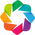

,name,id
0,Aureliano Buendia,id_0
1,Aureliano Segundo,id_1
2,Jose Arcadio Buendia,id_2
3,Jose Arcadio,id_3
4,Rebeca,id_4
5,Aureliano,id_5
6,Jose Arcadio Segundo,id_6
7,Gerineldo Marquez,id_7
8,Pietro Crespi,id_8
9,Meme,id_9


In [8]:
import holoviews as hv

hv.extension("bokeh")

hv_nodes = hv.Dataset(nodes, "index")
hv_nodes.data.head(10)

In [9]:
edges.dtypes

from      int64
to        int64
weight    int64
dtype: object

In [10]:
edges.tail()

,from,to,weight
240,59,56,7
241,70,5,37
242,70,7,1
243,70,8,1
244,70,11,2


In [11]:
from holoviews import opts, dim

hv.output(size=250)

chord = hv.Chord((edges, hv_nodes))
chord.opts(
    opts.Chord(
        cmap="Category10",
        edge_cmap="Category10",
        edge_color=dim("from").str(),
        labels="name",
        node_color=dim("index").str(),
        bgcolor="black",
        label_text_color="white",
        title="Character Co-occurrence in One Hundred Years of Solitude",
        edge_line_width=dim("weight"),
        edge_alpha=0.7,
        label_text_alpha=0.9,
    )
)

:Chord   [from,to]   (weight)

In [12]:
renderer = hv.renderer("bokeh")
renderer.save(chord, "chord_diagram")